<a href="https://colab.research.google.com/github/solverprime/dsnd-used-car-prices/blob/main/Used_car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# USED CARS ANALYTICS

# INTRODUCTION
## **QUESTIONS**
> Questions we will explore in this quest

> Q1. Which manufacturer's cars depreciate the fastest, and slowest, in their value over time? More specifically year

## **DATA**
> This data is Kaggle dataset available here:
  https://www.kaggle.com/austinreese/craigslist-carstrucks-data
  
## **CONTENT**
> This dataset contains relevant information on car sales on Craiglist. The main column of interest is the price of a car. The other relevant columns include manufacturer, condition and further specifications of the car.

## **AKNOWLEDGEMENT**

## **EVALUATION**
> We will use linear regression to train and test our models.


# Preparing to model

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install pandas_profiling
%pwd

'/content'

### File constants

In [2]:
# This Python Notebook runs on Google Colab. If you are running on a 
# local machine, specify the location of vehicles.csv below
DATA_ON_GDRIVE = True

# whether to combine Manufacturer and Model columns for each car
COMBINE_MANUFACTURER_MODEL = False


### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load the data

In [4]:
if DATA_ON_GDRIVE:
  # Mount the Google drive
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Load the data
  data = pd.read_csv('/content/gdrive/MyDrive/vehicles.csv')
else:
  data = pd.read_csv('/vehicles.csv')

data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,1G1YU3DW1A5106980,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,5NPEC4AB0EH813529,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,NaN,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,NaN,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


In [5]:
data.describe()

,Unnamed: 0,id,price,year,odometer,lat,long
count,458213.000000,4.582130e+05,4.582130e+05,457163.000000,4.029100e+05,450765.000000,450765.000000
mean,229106.000000,7.235233e+09,4.042093e+04,2010.746067,1.016698e+05,38.531925,-94.375824
std,132274.843786,4.594362e+06,8.194599e+06,8.868136,3.228623e+06,5.857378,18.076225
min,0.000000,7.208550e+09,0.000000e+00,1900.000000,0.000000e+00,-82.607549,-164.091797
25%,114553.000000,7.231953e+09,4.900000e+03,2008.000000,4.087700e+04,34.600000,-110.890427
50%,229106.000000,7.236409e+09,1.099500e+04,2013.000000,8.764100e+04,39.244500,-88.314889
75%,343659.000000,7.239321e+09,2.149500e+04,2016.000000,1.340000e+05,42.484503,-81.015022
max,458212.000000,7.241019e+09,3.615215e+09,2021.000000,2.043756e+09,82.049255,150.898969


# Data cleaning

### Drop irrelevant columns

In [6]:
# Drop rows with missing price values
data = data.dropna(subset=['price'], axis=0)
 
# Drop columns do not help with building a prediction model. 
data = data.drop(['Unnamed: 0', 'id', 'url','region','region_url', 'image_url','description','VIN',
                  'lat','long', 'posting_date','model'],axis=1)

data.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,35990,2010.0,chevrolet,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,al
1,7500,2014.0,hyundai,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,al
2,4900,2006.0,bmw,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,al
3,2000,1974.0,chevrolet,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,al
4,19500,2005.0,ford,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,al


In [7]:
if COMBINE_MANUFACTURER_MODEL:
  # create a combined column for "Manufacturer" and "Model" as "Model" column is a subset of "Manufacturer"
  # for example: "Manufacture"="BMW" has Models=[M1,M2...]
  data['car'] = data[['manufacturer','model']].apply(lambda x: str(x['manufacturer']) + ' '+ str(x['model']),axis=1)

  # Drop columns do not help with building a prediction model. 
  data = data.drop(['manufacturer','model'], axis = 1)


---
### Numerical Variables





In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,458213.0,40420.930696,8.194599e+06,0.0,4900.0,10995.0,21495.0,3.615215e+09
year,457163.0,2010.746067,8.868136e+00,1900.0,2008.0,2013.0,2016.0,2.021000e+03
odometer,402910.0,101669.756941,3.228623e+06,0.0,40877.0,87641.0,134000.0,2.043756e+09


---
### Categorical variables

In [9]:
data.describe(include=["object"]).T

,count,unique,top,freq
manufacturer,439993,43,ford,79666
condition,265273,6,good,115685
cylinders,287073,8,6 cylinders,105677
fuel,454976,5,gas,399399
title_status,455636,6,clean,439626
transmission,455771,3,automatic,396322
drive,324025,3,4wd,139693
size,136865,4,full-size,69736
type,345475,13,sedan,92364
paint_color,317370,12,white,82786


## Remove outliers


### Price
For price, we can see that this is really a problem

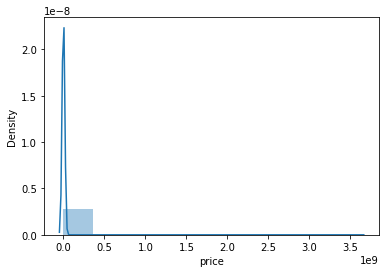

In [10]:
sns.distplot(data['price'], bins=10,kde_kws={'bw': 2})

In [11]:
for i in [1,5,10,50,90,95,99.9,99.99]:
  print("{}% of cars have prices below {}".format(i,data['price'].quantile(i/100)))
sum(data['price'] > 100000)

1% of cars have prices below 0.0
5% of cars have prices below 0.0
10% of cars have prices below 651.0
50% of cars have prices below 10995.0
90% of cars have prices below 33500.0
95% of cars have prices below 39990.0
99.9% of cars have prices below 119800.0
99.99% of cars have prices below 999999.1787999999


596

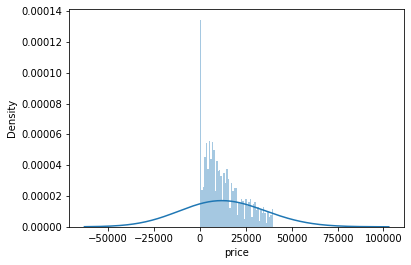

In [12]:
sns.distplot(data['price'].loc[data['price'] < 40000], bins=50,kde_kws={'bw': 2})

Two observations from the above plot:

1.   There are lots of extremely small values i.e. price = 0?
2.   Log transformation of prices would make our **price** columns more "normal" looking and better fit our prediction models.



In [13]:
print("There are {} listings with price = 0, and {} listings have price below 1".format(sum(data['price']==0), sum(data['price']<=1)))


There are 33753 listings with price = 0, and 35230 listings have price below 1


> Let's remove the outlier listings by price

In [14]:
data = data.loc[(data['price'] >= 500) & (data['price'] <= 40000)]

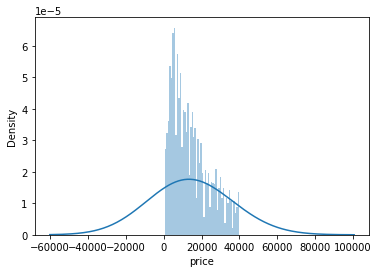

In [15]:
sns.distplot(data['price'], bins=50,kde_kws={'bw': 2})

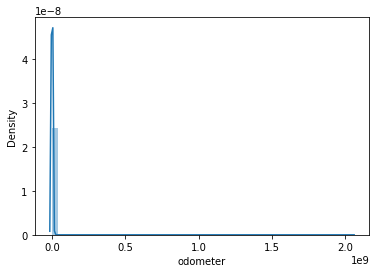

In [16]:
sns.distplot(data['odometer'], bins=50,kde_kws={'bw': 1.5})

### Odometer

In [17]:
for i in [1,5,10,50,90,95,99.9,99.99]:
  print("{}% of cars have mileage below {:d}".format(i,int(data['odometer'].quantile(i/100))))

print("\n{} cars have mileage over 200000".format(sum(data['odometer'] > 200000) ))
print("{} cars have mileage over 300000".format(sum(data['odometer'] > 300000) ))

print("\nThere are {} listings with odomoter = 0, and {} listings are cars from before 2020".format(sum(data['odometer']==0), sum(data[data['odometer']==0]['year'] < 2020)))

print("\n{} have mileage below 10".format(sum(data['odometer'] <= 10) ))
print("{} have mileage below 100".format(sum(data['odometer'] <= 100) ))
print("{} have mileage below 1000".format(sum(data['odometer'] <= 1000) ))

1% of cars have mileage below 105
5% of cars have mileage below 10298
10% of cars have mileage below 20128
50% of cars have mileage below 94000
90% of cars have mileage below 180192
95% of cars have mileage below 206791
99.9% of cars have mileage below 1069967
99.99% of cars have mileage below 9999999

20561 cars have mileage over 200000
2138 cars have mileage over 300000

There are 1177 listings with odomoter = 0, and 1145 listings are cars from before 2020

2343 have mileage below 10
3403 have mileage below 100
6934 have mileage below 1000


> Based on the above, let's exclude listings with mileage below 100 and over 300,000 as we are focused on *used* car analysis and it will improve prediction of our algorithm

In [18]:
data = data.loc[(data['odometer'] >= 100) & (data['odometer'] <= 300000)]

### Year

In [19]:
for i in [1,5,10,50,90,95,99.9,99.99]:
  print("{}% of cars have a vintage year earlier than {:d}".format(i,int(data['year'].quantile(i/100))))

1% of cars have a vintage year earlier than 1980
5% of cars have a vintage year earlier than 2000
10% of cars have a vintage year earlier than 2003
50% of cars have a vintage year earlier than 2012
90% of cars have a vintage year earlier than 2018
95% of cars have a vintage year earlier than 2019
99.9% of cars have a vintage year earlier than 2020
99.99% of cars have a vintage year earlier than 2021


> Based on the above, let's keep years 2000-2020

In [20]:
data = data.loc[(data['year'] >= 2000) & (data['year'] <= 2020)]

### Scaling Year and Odometer

1. **Year**: Lets make the max year equal to zero, so we can better interpret the _year_ column as the number of years a car is old. 
2. **Odometer**: dividing mileage of a car by 1000 makes it easier to understand

In [21]:
data['year'] = (data['year'] - 2000).astype(int)
data['odometer'] = (data['odometer']/1000)

### Correlations

In [22]:
data.describe()

,price,year,odometer
count,325885.000000,325885.000000,325885.000000
mean,15145.781417,12.009061,96.669308
std,10107.930898,4.833403,59.094158
min,500.000000,0.000000,0.100000
25%,6900.000000,8.000000,46.894000
50%,12990.000000,13.000000,93.401000
75%,21990.000000,16.000000,137.605000
max,40000.000000,20.000000,300.000000


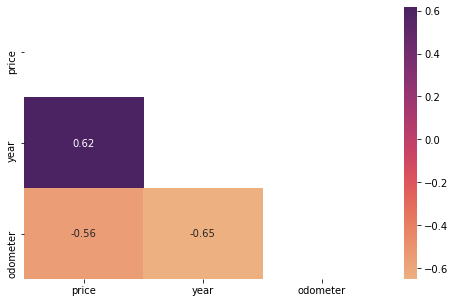

In [23]:
plt.figure(figsize=(8,5))
corr=data.corr()
mask=np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr,annot=True,cmap="flare",mask=mask);
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5});

#### Observations


1. 0.62 correlation between year and price of a car
2. -0.56 correlation between odometer and price of a car



### Drop missing data

In [24]:
data_na = 100 * (data.isnull().sum() / len(data))
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'% missing':round(data_na,1)})
missing_data.head(20)

,% missing
size,68.7
condition,36.9
cylinders,32.8
drive,24.6
paint_color,24.4
type,18.5
manufacturer,2.3
fuel,0.6
title_status,0.4
transmission,0.4


In [25]:
df = data.dropna()
df.reset_index(inplace=True)
df = df.drop(['index'],axis=1)
print(df.shape)
df.head()

(74740, 14)


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,19500,5,ford,excellent,8 cylinders,diesel,116.000,lien,automatic,4wd,full-size,pickup,blue,al
1,4900,3,ford,good,8 cylinders,gas,177.000,clean,automatic,rwd,full-size,SUV,blue,al
2,6250,10,ford,good,6 cylinders,gas,82.000,clean,automatic,fwd,full-size,sedan,silver,al
3,27500,15,jeep,like new,6 cylinders,gas,84.000,lien,automatic,4wd,full-size,SUV,white,al
4,24999,16,mercedes-benz,like new,4 cylinders,gas,18.823,clean,automatic,rwd,full-size,sedan,white,al


### Format numerical columns
Convert year and odometer i.e. mileage, to integers from float

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74740 entries, 0 to 74739
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         74740 non-null  int64  
 1   year          74740 non-null  int64  
 2   manufacturer  74740 non-null  object 
 3   condition     74740 non-null  object 
 4   cylinders     74740 non-null  object 
 5   fuel          74740 non-null  object 
 6   odometer      74740 non-null  float64
 7   title_status  74740 non-null  object 
 8   transmission  74740 non-null  object 
 9   drive         74740 non-null  object 
 10  size          74740 non-null  object 
 11  type          74740 non-null  object 
 12  paint_color   74740 non-null  object 
 13  state         74740 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 8.0+ MB


## The Top 10 most popular manufacturers

In [27]:
top10_cars = df.manufacturer.value_counts().head(10)
print("Total number of cars: {}".format(df.shape[0]))
print(pd.DataFrame({"# listings":top10_cars,"% of total" : round(top10_cars*100/df.shape[0],1)}))

Total number of cars: 74740
           # listings  % of total
ford            13392        17.9
chevrolet       10764        14.4
toyota           6888         9.2
honda            5280         7.1
nissan           4434         5.9
jeep             2977         4.0
gmc              2800         3.7
dodge            2733         3.7
ram              2345         3.1
hyundai          2102         2.8


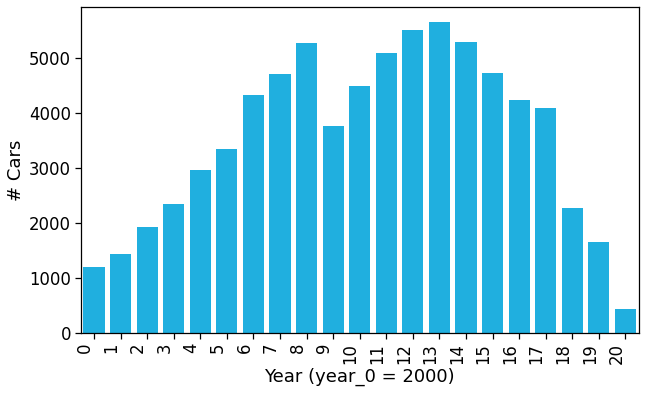

In [28]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x='year',data=df,color='#00BFFF');#,palette="Blues");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");
ax.set(xlabel='Year (year_0 = 2000)',ylabel='# Cars')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5});

#### Observations
> Interesting to see a drop in 2009 from 2008, which must be due to the Global Financial Crisis. It did pick up in the following years.

> We also observe a huge few drop from cars listed 3 years and older to cars listed  are listed that are less than 2 years old. It could be that people generally prefer to drive a car for atleast 2-3 years before bringing it to the used car market.

# Prediction model

## Build the variables

In [29]:
cat_col_count = dict()
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # TODO: make sure that there are at least 10 unique rows, ie. cars,
    # for each attribute we want to make a column to have
    # a meaningful training set
    # df = df[df.groupby(var)[var].transform('size') >= 1]

    # make a record of the unique column attribute
    cat_col_count[var] = len(df[var].unique())
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)


df.reset_index(inplace=True)
y = df['price']
X = df.drop(['price','index'], axis=1)

print(pd.DataFrame(cat_col_count,index=['Categorical_variables']).transpose())
print("Shape of X (specifications of a car): {}".format(X.shape))
print("Number of y (price of a car): {}".format(y.shape[0]))

              Categorical_variables
manufacturer                     39
condition                         6
cylinders                         8
fuel                              5
title_status                      6
transmission                      3
drive                             3
size                              4
type                             13
paint_color                      12
state                            51
Shape of X (specifications of a car): (74740, 141)
Number of y (price of a car): 74740


### Find the optimal linear regression model for our data

In [30]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    SOURCE: taken from Udacity - Data Science course
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

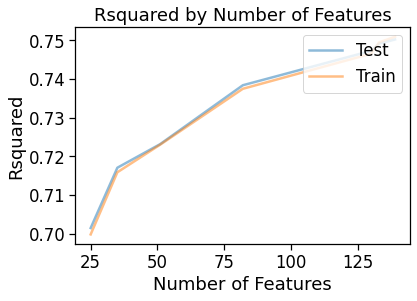

In [31]:
# cutoffs here pertains to the number of missing values allowed in the used columns.
# Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3000, 2000, 1000, 100, 50, 10]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [34]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

139
0.7502517290488201
0.7509545020996449


In [36]:
print(X_train.shape)
print(X_test.shape)
print(X.shape)
print(data.shape)
print(df.shape)

(52318, 139)
(22422, 139)
(74740, 141)
(325885, 14)
(74740, 143)


### Determine how features of a car affect its price 

In [37]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    SOURCE: modified version from Udacity - Data Science course
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, abs(estimate), 
    count_total, count_train, car_type, var_subtype
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['var'] = X_train.columns
    coefs_df['coef'] = lm_model.coef_
    coefs_df['abs_coef'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coef', ascending=False)
    tmp = pd.DataFrame({'count_total':X.apply(lambda x: sum(x>0),axis=0),
     'count_train':X_train.apply(lambda x: sum(x>0),axis=0)})
    coefs_df = coefs_df.merge(tmp.reset_index().rename(columns={'index':'var'}), 
                            on='var',how='left').sort_values(by=['abs_coef'],ascending=False)

    coefs_df['var_type'] = coefs_df['var'].apply(lambda x: x.split('_')[0])
    coefs_df['var_subtype'] = coefs_df['var'].apply(lambda x: x.split('_')[1] if '_' in x else None)
    return coefs_df

# get the coefficient weights
coef_df = coef_weights(lm_model.coef_, X_train)

# aquick look at the top results
coef_df.head(20)

,var,coef,abs_coef,count_total,count_train,var_type,var_subtype
0,manufacturer_tesla,18272.100188,18272.100188,23,16.0,manufacturer,tesla
1,fuel_electric,-11075.393874,11075.393874,153,100.0,fuel,electric
2,fuel_other,-9796.959031,9796.959031,100,73.0,fuel,other
3,cylinders_3 cylinders,-9312.373686,9312.373686,100,71.0,cylinders,3 cylinders
4,manufacturer_fiat,-7806.717053,7806.717053,147,99.0,manufacturer,fiat
5,fuel_gas,-7513.349550,7513.349550,69692,48817.0,fuel,gas
6,cylinders_12 cylinders,7486.526937,7486.526937,16,12.0,cylinders,12 cylinders
7,fuel_hybrid,-7254.282876,7254.282876,1256,861.0,fuel,hybrid
8,cylinders_4 cylinders,-6392.333503,6392.333503,28280,19871.0,cylinders,4 cylinders
9,title_status_parts only,-6162.256194,6162.256194,19,13.0,title,status


### Influence of a car's vintage year and mileage on its price

In [38]:
coef_df[coef_df['var'].isin(['odometer','year'])]

,var,coef,abs_coef,count_total,count_train,var_type,var_subtype
99,year,912.791847,912.791847,73547,51502.0,year,None
135,odometer,-44.110507,44.110507,74740,52318.0,odometer,None


#### Observations
- The price of a car decreases by \$ 912.8 each year, given that all other factors remain the same
- The price of a car decreases by \$ 44.1 for each 1,000 miles it is driven, given that all other factors remain the same



### Influence of categorical features on car price

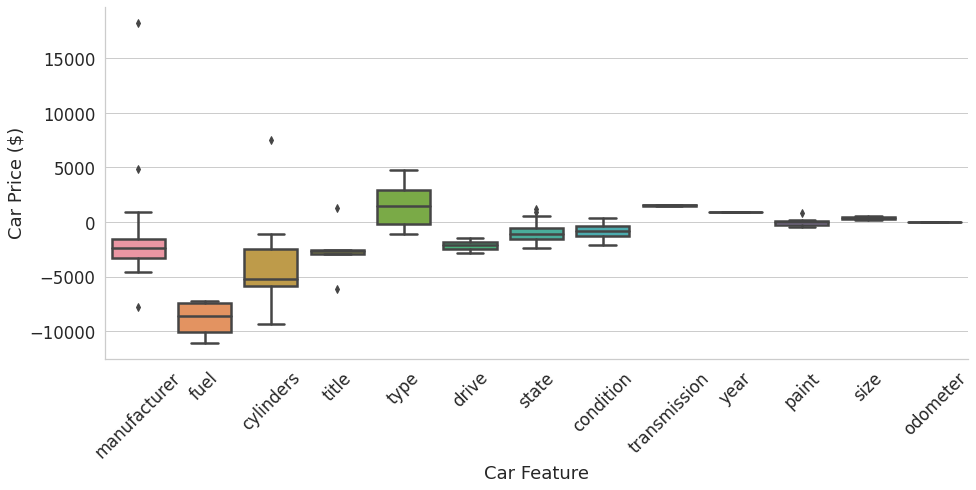

In [39]:
#sns.set_context("talk")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

sns.set_style("whitegrid")
g = sns.catplot(x="var_type", y="coef", kind="box", data=coef_df)
g.set(xlabel='Car Feature', ylabel='Car Price ($)')
g.set_xticklabels(rotation=45)
g.fig.set_size_inches(20,6)


#### Observations
- The car's manufacturer and the number of cylinders it has cause the largest variability in the price of a car
- Other variables that impact the price of a car seem to have low variability

In [40]:
coef_df[coef_df['var_type']=='manufacturer'].describe()

,coef,abs_coef,count_total,count_train
count,36.000000,36.000000,36.000000,36.000000
mean,-1802.534673,3144.193850,2055.388889,1438.361111
std,3975.223538,2995.989806,2917.574485,2041.313417
min,-7806.717053,37.021321,15.000000,8.000000
25%,-3335.640878,1736.807647,402.750000,277.500000
50%,-2348.768377,2616.131477,1096.500000,765.500000
75%,-1568.162270,3635.303307,2162.750000,1527.000000
max,18272.100188,18272.100188,13392.000000,9378.000000
